In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion, make_pipeline

import matplotlib.pyplot as plt
%matplotlib inline

import dask.dataframe as dd
from datetime import datetime, date, time
import pickle

import warnings
warnings.filterwarnings("ignore")

# Для получения версии
import sklearn
import matplotlib
import dask

### Версии библиотек

In [2]:
print(f'The numpy version is {np.__version__}.')
print(f'The pandas version is {pd.__version__}.')
print(f'The dask version is {dask.__version__}.')
print(f'The sklearn version is {sklearn.__version__}.')
print(f'The matplotlib version is {matplotlib.__version__}.')

The numpy version is 1.20.1.
The pandas version is 1.2.4.
The dask version is 2021.04.0.
The sklearn version is 0.24.1.
The matplotlib version is 3.3.4.


In [3]:
path_train = 'data_train.csv'
path_test = 'data_test.csv'
path_features = 'features.csv'
path_pred = 'answers_test.csv'
MODEL_FILE_PATH = 'model.pkl'

### Загрузка данных

In [4]:
df_train = pd.read_csv(path_train)
df_test = pd.read_csv(path_test)

In [5]:
df_train['buy_time'] = df_train['buy_time'].apply(lambda x: date.fromtimestamp(x))
df_test['buy_time'] = df_test['buy_time'].apply(lambda x: date.fromtimestamp(x))

In [6]:
df_train.head()

,Unnamed: 0,id,vas_id,buy_time,target
0,0,540968,8.0,2018-09-17,0.0
1,1,1454121,4.0,2018-07-16,0.0
2,2,2458816,1.0,2018-08-13,0.0
3,3,3535012,5.0,2018-09-03,0.0
4,4,1693214,1.0,2018-09-03,0.0


In [7]:
df_features = dd.read_csv('features.csv', sep='\t')
df_features['buy_time'] = df_features['buy_time'].apply(lambda x: date.fromtimestamp(x), meta=('buy_time', 'object'))
df_features.head()

,Unnamed: 0,id,buy_time,0,1,2,3,4,5,6,...,243,244,245,246,247,248,249,250,251,252
0,0,2013026,2018-07-16,18.910029,46.980888,4.969214,-1.386798,3.791754,-14.01179,-16.08618,...,-977.373846,-613.770792,-25.996269,-37.630448,-301.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
1,1,2014722,2018-10-15,36.690029,152.400888,448.069214,563.833202,463.841754,568.99821,-16.08618,...,-891.373846,-544.770792,-20.996269,48.369552,80.252276,-13.832889,-0.694428,-1.175933,-0.45614,0.0
2,2,2015199,2018-12-24,-67.019971,157.050888,-63.180786,178.103202,-68.598246,156.99821,3.51382,...,-977.373846,-613.770792,-12.996269,-37.630448,10829.252276,-25.832889,-0.694428,-12.175933,-0.45614,0.0
3,3,2021765,2018-08-13,7.010029,150.200888,-6.930786,216.213202,76.621754,351.84821,-16.08618,...,-973.373846,-613.770792,-23.996269,-37.630448,-205.747724,-24.832889,-0.694428,-11.175933,-0.45614,1.0
4,4,2027465,2018-08-06,-90.439971,134.220888,-104.380786,153.643202,-109.798246,132.53821,-16.08618,...,1643.626154,2007.229208,206.003731,-21.630448,6667.252276,92.167111,-0.694428,49.824067,47.54386,0.0


In [8]:
df_merge = dd.merge(df_train, df_features, on=['id', 'buy_time'], how='inner')
df_merge_test = dd.merge(df_test, df_features, on=['id', 'buy_time'], how='inner')

In [9]:
#Перевод из dask в pandas
#pandas_df = dask_df.compute()
df_merge = df_merge.compute()
df_merge_test = df_merge_test.compute()

In [10]:
df_merge.describe()

,Unnamed: 0_x,id,vas_id,target,Unnamed: 0_y,0,1,2,3,4,...,243,244,245,246,247,248,249,250,251,252
count,38919.000000,3.891900e+04,38919.000000,38919.000000,3.891900e+04,38919.000000,38919.000000,38919.000000,38919.000000,38919.000000,...,38919.000000,38919.000000,38919.000000,38919.000000,38919.000000,38919.000000,38919.000000,38919.000000,38919.000000,38919.000000
mean,419486.076004,2.154005e+06,2.801562,0.067885,2.259702e+06,-0.653179,-1.564541,-1.144136,-2.513602,-1.225731,...,-18.027794,-3.666550,0.361963,-0.543627,-17.829663,-2.040782,-0.024627,-1.846917,0.003353,0.257843
std,240312.262815,1.262414e+06,1.978314,0.251551,1.309179e+06,194.172807,399.922474,204.543990,451.883977,229.993395,...,3167.200100,2225.590690,1081.353728,288.871988,1086.209541,145.695314,6.176294,97.109281,5.616058,0.557951
min,37.000000,2.000000e+00,1.000000,0.000000,1.580000e+02,-411.719971,-468.019112,-421.420786,-512.156798,-426.838246,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.456140,0.000000
25%,212346.500000,1.064699e+06,1.000000,0.000000,1.117424e+06,-96.799971,-212.474112,-110.740786,-244.656798,-116.158246,...,-977.373846,-613.770792,-25.996269,-37.630448,-305.747724,-25.832889,-0.694428,-12.175933,-0.456140,0.000000
50%,419399.000000,2.132826e+06,2.000000,0.000000,2.261589e+06,-86.199971,-61.669112,-87.160786,-79.426798,-90.378246,...,-959.373846,-613.770792,-25.996269,-37.630448,-239.747724,-23.832889,-0.694428,-12.175933,-0.456140,0.000000
75%,625607.000000,3.249143e+06,5.000000,0.000000,3.390411e+06,9.505029,115.855888,24.694214,122.128202,24.906754,...,-497.373846,-411.770792,-24.996269,-32.630448,-80.747724,-10.832889,-0.694428,-9.175933,-0.456140,1.000000
max,831628.000000,4.362640e+06,9.000000,1.000000,4.512309e+06,9235.090029,20564.850888,9221.149214,20641.873202,10900.661754,...,141554.626154,72800.229208,150072.003731,21326.369552,40816.252276,9120.167111,582.305572,9131.824067,508.543860,68.000000


### Получаем тренировочный набор данных

In [11]:
df_merge['target'] = df_merge['target'].astype(int)

In [12]:
X_train = df_merge.drop('target', axis=1)
X_test = df_merge_test

In [13]:
Y_train = df_merge['target']

In [14]:
y_list = []
y_list.append(df_train[df_train['target']==0].shape[0])
y_list.append(df_train[df_train['target']==1].shape[0])
print(f'target = 0 - {y_list[0]}, target = 1 - {y_list[1]}')

target = 0 - 771467, target = 1 - 60186


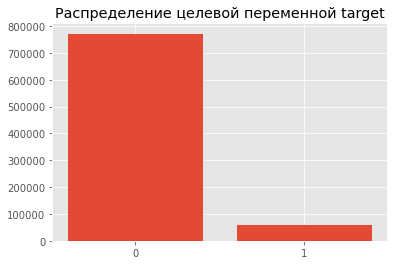

In [15]:
plt.style.use('ggplot')
fig, ax = plt.subplots()
ax.bar(np.arange(2), y_list)
ax.set(xticks=np.arange(2))
ax.set_title('Распределение целевой переменной target')
plt.show()

### Балансировка классов

In [16]:
### Так как между двумя классами существует существенный дисбаланс, 
### необходимо уравнять количество значений целевой переменной (0, 1), для более качественного обучения моделей

In [17]:
def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    return df.sample(frac=1) 

In [18]:
df_for_balancing = pd.concat([X_train, Y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, 'target', method='under') 
df_balanced['target'].value_counts()

0    2642
1    2642
Name: target, dtype: int64

In [19]:
X_train = df_balanced.drop('target', axis=1)
Y_train = df_balanced['target']

### Определение типа признаков

In [20]:
# Составление списка колонок датафрейма
columns = [col for col in X_train.columns]

In [21]:
# Выбор признаков для обработки в pipline 
for x in ['Unnamed: 0_x', 'Unnamed: 0_y']:
    columns.remove(x)

In [22]:
columns

['id',
 'vas_id',
 'buy_time',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '70',
 '71',
 '72',
 '73',
 '74',
 '75',
 '76',
 '77',
 '78',
 '79',
 '80',
 '81',
 '82',
 '83',
 '84',
 '85',
 '86',
 '87',
 '88',
 '89',
 '90',
 '91',
 '92',
 '93',
 '94',
 '95',
 '96',
 '97',
 '98',
 '99',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '110',
 '111',
 '112',
 '113',
 '114',
 '115',
 '116',
 '117',
 '118',
 '119',
 '120',
 '121',
 '122',
 '123',
 '124',
 '125',
 '126',
 '127',
 '128',
 '129',
 '130',
 '131',
 '132',
 '133',
 '134',

In [23]:
# Преобразуем признак buy_time в год
X_train['buy_time'] = X_train['buy_time'].apply(lambda x: x.year)
#X_test['buy_time'] = X_test['buy_time'].apply(lambda x: x.year)

In [24]:
X_train = X_train[columns]
X_test = X_test[columns]

In [25]:
def find_feature(X_train):
    #### Просмотр и оценка признаков
    X_nunique = X_train.apply(lambda x: x.nunique(dropna=False))
    f_all = set(X_nunique.index.tolist())


    # константные признаки
    f_const = set(X_nunique[X_nunique == 1].index.tolist())

    # вещественные признаки
    f_numeric = (X_train.fillna(0).astype(int).sum() - X_train.fillna(0).sum()).abs()
    f_numeric = set(f_numeric[f_numeric > 0].index.tolist())

    f_other = f_all - (f_numeric | f_const)

    # бинарные
    f_binary = set(X_train.loc[:, f_other].columns[(
                          (X_train.loc[:, f_other].max() == 1) & \
                          (X_train.loc[:, f_other].min() == 0) & \
                          (X_train.loc[:, f_other].isnull().sum() == 0))])

    f_other = f_other - f_binary

    #### категориальные
    f_categorical = set(X_nunique.loc[f_other][X_nunique.loc[f_other] <= 10].index.tolist())

    f_numeric_extra = f_categorical
    f_other = f_other - f_categorical
    f_numeric = f_numeric | f_other
    f_other = f_other - f_numeric

    print(f'Все признаки {len(f_all)}')
    print(f'Константные признаки {len(f_const)}')
    print(f'Вещественные признаки {len(f_numeric)}')
    print(f'Бинарные признаки {len(f_binary)}')
    print(f'Категориальные признаки {len(f_categorical)}')
    print(f'Остальные признаки {len(f_other)}')
    f_ok = list(f_binary | f_categorical | f_numeric)
    f_const, f_binary, f_categorical, f_numeric = list(f_const), list(f_binary), list(f_categorical), list(f_numeric)
    
    return f_ok, f_const, f_binary, f_categorical, f_numeric

### Создание пайплайна

In [26]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("DataFrame не содердит следующие колонки: %s" % cols_error)

In [27]:
f_ok, f_const, f_binary, f_categorical, f_numeric = find_feature(X_train)

Все признаки 256
Константные признаки 16
Вещественные признаки 248
Бинарные признаки 1
Категориальные признаки 1
Остальные признаки 0


In [28]:
f_prep_pipeline = make_pipeline(
    ColumnSelector(columns=f_ok),
    FeatureUnion(transformer_list=[
        ("numeric_features", make_pipeline(
            ColumnSelector(f_numeric),
            SimpleImputer(strategy="mean"),
            StandardScaler()
        )),
        ("categorical_features", make_pipeline(
            ColumnSelector(f_categorical),
            SimpleImputer(strategy="most_frequent"),
            OneHotEncoder(handle_unknown='ignore')
        )),
        ("boolean_features", make_pipeline(
            ColumnSelector(f_binary),
        ))
    ])
)

In [29]:
f_prep_pipeline.steps

[('columnselector',
  ColumnSelector(columns=['214', '46', '34', '136', '116', '74', '51', '19',
                          '158', '231', '60', '183', '18', '185', '248', '66',
                          '70', '133', '137', '170', '177', '117', '88', '216',
                          '129', '163', '230', '43', '104', '140', ...])),
 ('featureunion',
  FeatureUnion(transformer_list=[('numeric_features',
                                  Pipeline(steps=[('columnselector',
                                                   ColumnSelector(columns=['214',
                                                                           '46',
                                                                           '34',
                                                                           '136',
                                                                           '116',
                                                                           '74',
                                       

In [30]:
f_prep_pipeline.fit(X_train)
n_features = f_prep_pipeline.transform(X_train).shape[1]
print(f'Количество обработанных признаков с помощью fit, transfofm - {n_features}')

Количество обработанных признаков с помощью fit, transfofm - 257


In [31]:
f_prep_pipeline

Pipeline(steps=[('columnselector',
                 ColumnSelector(columns=['214', '46', '34', '136', '116', '74',
                                         '51', '19', '158', '231', '60', '183',
                                         '18', '185', '248', '66', '70', '133',
                                         '137', '170', '177', '117', '88',
                                         '216', '129', '163', '230', '43',
                                         '104', '140', ...])),
                ('featureunion',
                 FeatureUnion(transformer_list=[('numeric_features',
                                                 Pipeline(steps=[('columnselector',
                                                                  ColumnSelector(...
                                                                  SimpleImputer()),
                                                                 ('standardscaler',
                                                                  Standar

### Gridsearch для пайплайнов

In [32]:
RANDOM_STATE = 1

#### Логистическая регрессия

In [33]:
lg_pipe = make_pipeline(
    f_prep_pipeline,
    LogisticRegression(random_state=RANDOM_STATE)
)

In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

In [35]:
kfold_cv = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

In [36]:
def run_grid_search(estimator, X, y, params_grid, cv, scoring='f1'):
    gsc = GridSearchCV(estimator, params_grid, scoring=scoring, cv=cv, n_jobs=-1)

    gsc.fit(X, y)
    print("Best %s score: %.2f" % (scoring, gsc.best_score_))
    print()
    print("Best parameters set found on development set:")
    print()
    print(gsc.best_params_)
    print()
    print("Grid scores on development set:")
    print()

    for i, params in enumerate(gsc.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (gsc.cv_results_['mean_test_score'][i], gsc.cv_results_['std_test_score'][i] * 2, params))

    print()
    
    return gsc

In [37]:
[k for k in lg_pipe.get_params().keys() if 'imputer' in k]

['pipeline__featureunion__numeric_features__simpleimputer',
 'pipeline__featureunion__numeric_features__simpleimputer__add_indicator',
 'pipeline__featureunion__numeric_features__simpleimputer__copy',
 'pipeline__featureunion__numeric_features__simpleimputer__fill_value',
 'pipeline__featureunion__numeric_features__simpleimputer__missing_values',
 'pipeline__featureunion__numeric_features__simpleimputer__strategy',
 'pipeline__featureunion__numeric_features__simpleimputer__verbose',
 'pipeline__featureunion__categorical_features__simpleimputer',
 'pipeline__featureunion__categorical_features__simpleimputer__add_indicator',
 'pipeline__featureunion__categorical_features__simpleimputer__copy',
 'pipeline__featureunion__categorical_features__simpleimputer__fill_value',
 'pipeline__featureunion__categorical_features__simpleimputer__missing_values',
 'pipeline__featureunion__categorical_features__simpleimputer__strategy',
 'pipeline__featureunion__categorical_features__simpleimputer__verbos

In [38]:
param_grid = {
    "pipeline__featureunion__categorical_features__simpleimputer__strategy": ['most_frequent', 'constant'],
    "pipeline__featureunion__categorical_features__simpleimputer__fill_value": [-1],
}

In [39]:
lg_gsc = run_grid_search(lg_pipe, X_train, Y_train, param_grid, kfold_cv)

Best f1 score: 0.85

Best parameters set found on development set:

{'pipeline__featureunion__categorical_features__simpleimputer__fill_value': -1, 'pipeline__featureunion__categorical_features__simpleimputer__strategy': 'most_frequent'}

Grid scores on development set:

0.853 (+/-0.005) for {'pipeline__featureunion__categorical_features__simpleimputer__fill_value': -1, 'pipeline__featureunion__categorical_features__simpleimputer__strategy': 'most_frequent'}
0.853 (+/-0.005) for {'pipeline__featureunion__categorical_features__simpleimputer__fill_value': -1, 'pipeline__featureunion__categorical_features__simpleimputer__strategy': 'constant'}



#### Градиентный бустинг

In [40]:
gb_fs_pipe = make_pipeline(
    f_prep_pipeline,
    GradientBoostingClassifier()
)

In [41]:
[k for k in gb_fs_pipe.get_params().keys() if 'grad' in k]

['gradientboostingclassifier',
 'gradientboostingclassifier__ccp_alpha',
 'gradientboostingclassifier__criterion',
 'gradientboostingclassifier__init',
 'gradientboostingclassifier__learning_rate',
 'gradientboostingclassifier__loss',
 'gradientboostingclassifier__max_depth',
 'gradientboostingclassifier__max_features',
 'gradientboostingclassifier__max_leaf_nodes',
 'gradientboostingclassifier__min_impurity_decrease',
 'gradientboostingclassifier__min_impurity_split',
 'gradientboostingclassifier__min_samples_leaf',
 'gradientboostingclassifier__min_samples_split',
 'gradientboostingclassifier__min_weight_fraction_leaf',
 'gradientboostingclassifier__n_estimators',
 'gradientboostingclassifier__n_iter_no_change',
 'gradientboostingclassifier__random_state',
 'gradientboostingclassifier__subsample',
 'gradientboostingclassifier__tol',
 'gradientboostingclassifier__validation_fraction',
 'gradientboostingclassifier__verbose',
 'gradientboostingclassifier__warm_start']

In [42]:
param_grid = {
    "gradientboostingclassifier__max_depth": [3, 5],
    "gradientboostingclassifier__n_estimators": [50, 100]
}

In [43]:
gb_fs_gsc = run_grid_search(gb_fs_pipe, X_train, Y_train, param_grid, kfold_cv)

Best f1 score: 0.88

Best parameters set found on development set:

{'gradientboostingclassifier__max_depth': 3, 'gradientboostingclassifier__n_estimators': 100}

Grid scores on development set:

0.872 (+/-0.007) for {'gradientboostingclassifier__max_depth': 3, 'gradientboostingclassifier__n_estimators': 50}
0.876 (+/-0.005) for {'gradientboostingclassifier__max_depth': 3, 'gradientboostingclassifier__n_estimators': 100}
0.875 (+/-0.003) for {'gradientboostingclassifier__max_depth': 5, 'gradientboostingclassifier__n_estimators': 50}
0.874 (+/-0.003) for {'gradientboostingclassifier__max_depth': 5, 'gradientboostingclassifier__n_estimators': 100}



### Сравнение моделей

In [44]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          model_name="",
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest',  cmap=cmap)
    
    plt.grid(False)
    plt.title('%s: confusion matrix' % model_name)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [45]:
lg_model = lg_gsc.best_estimator_
lg_model.fit(X_train, Y_train)
y_test_lg = lg_model.predict_proba(X_train)[:,1]

In [46]:
print('Логистическая регрессия')
print(classification_report(Y_train, y_test_lg > 0.5))

Логистическая регрессия
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      2642
           1       0.88      0.86      0.87      2642

    accuracy                           0.87      5284
   macro avg       0.87      0.87      0.87      5284
weighted avg       0.87      0.87      0.87      5284



Confusion matrix, without normalization
[[2337  305]
 [ 366 2276]]


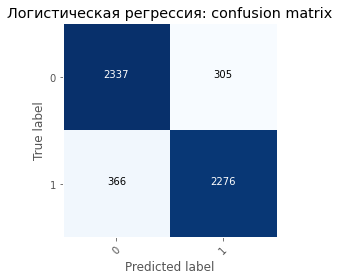

In [47]:
cm = confusion_matrix(Y_train, y_test_lg > 0.5)
plot_confusion_matrix(cm, classes=["0", "1"], model_name="Логистическая регрессия");

In [48]:
gb_model = gb_fs_gsc.best_estimator_
gb_model.fit(X_train, Y_train)
y_test_gb = gb_model.predict_proba(X_train)[:,1]

In [49]:
print('Градиентный бустинг')
print(classification_report(Y_train, y_test_gb > 0.5))

Градиентный бустинг
              precision    recall  f1-score   support

           0       0.88      0.89      0.89      2642
           1       0.89      0.88      0.89      2642

    accuracy                           0.89      5284
   macro avg       0.89      0.89      0.89      5284
weighted avg       0.89      0.89      0.89      5284



Confusion matrix, without normalization
[[2350  292]
 [ 310 2332]]


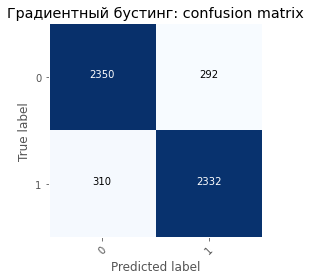

In [50]:
cm = confusion_matrix(Y_train, y_test_gb > 0.5)
plot_confusion_matrix(cm, classes=["0", "1"], model_name="Градиентный бустинг");

### Лучшая модель

#### Выбрана модель градиентного бустинга, т.к. у неё true negativ true positiv лучше, чем у логистической регрессии

In [51]:
#final_model = gb_fs_gsc.best_estimator_
#final_model.fit(X_train, Y_train)

In [52]:
final_model = gb_model
y_test_preds = final_model.predict_proba(X_test)[:,1]

In [53]:
y_test_preds[y_test_preds >= 0.5] = 1
y_test_preds[y_test_preds < 0.5] = 0

### Сохранение модели

In [54]:
with open(MODEL_FILE_PATH, 'wb') as f:
    pickle.dump(final_model, f)

### Сохранение прогнозов

In [55]:
df_y_pred = pd.DataFrame({'id' : X_test['id'], 'vas_id': X_test['vas_id'], 'buy_time' : X_test['buy_time'] , 'target' : y_test_preds})
df_y_pred.to_csv(path_pred, index=False, encoding='utf-8')
df_y_pred.head()

,id,vas_id,buy_time,target
0,3504271,5.0,2019-01-21,0.0
1,2543272,2.0,2019-01-14,0.0
2,4066976,2.0,2019-01-14,0.0
0,3456715,2.0,2019-01-14,0.0
1,3987315,5.0,2019-01-14,0.0
